In [2]:
import numpy as np 
import io
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from PIL import Image
import torch
import torch.nn as nn
from matplotlib import gridspec
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATASET

- You must use the Huggingface Emoji dataset for this project
- You should divide this subset into training, validation and test sets using a 60/20/20 ratio.

In [3]:

# Load the "emoji-dataset"
dataset = load_dataset("valhalla/emoji-dataset")
def split_dataset(dataset):
    # Split the dataset into training, testing, and validation sets
    train_ratio = 0.6
    test_ratio = 0.4
    validation_ratio = 0.5

    # Use the train_test_split function to create the splits
    splits = dataset["train"].train_test_split(
        test_size=test_ratio,
        train_size=train_ratio,
        shuffle=True,
        # split_seed=42  # You can change this seed for reproducibility
    )

    # Access the resulting splits
    train_dataset = splits["train"]
    test_dataset = splits["test"]

    # Further split the train_dataset for validation
    train_splits = test_dataset.train_test_split(
        test_size=validation_ratio,
        train_size=1 - validation_ratio,
        shuffle=True,
        # split_seed=42
    )

    # Access the resulting splits
    test_dataset = train_splits["train"]
    validation_dataset = train_splits["test"]

    # Print the number of examples in each split
    print(f"Train: {len(train_dataset)} examples")
    print(f"Test: {len(test_dataset)} examples")
    print(f"Validation: {len(validation_dataset)} examples")
    return train_dataset, test_dataset, validation_dataset

train_dataset, test_dataset, validation_dataset = split_dataset(dataset)

Train: 1649 examples
Test: 550 examples
Validation: 550 examples


- You should use the image “text” to select a related subset of images to work with (e.g.,
“face”, “superhero”, etc.).

In [4]:
## Specify the text you want to match
def filter_training(dataset, target_text) :

    # Function to filter images based on text
    def filter_by_text(example):
        return target_text in example["text"]

    # Apply the filter function to get matching examples
    matching_examples = train_dataset.filter(filter_by_text)
    return matching_examples


Filter:   0%|          | 0/1649 [00:00<?, ? examples/s]

Filter: 100%|██████████| 1649/1649 [00:03<00:00, 485.13 examples/s]


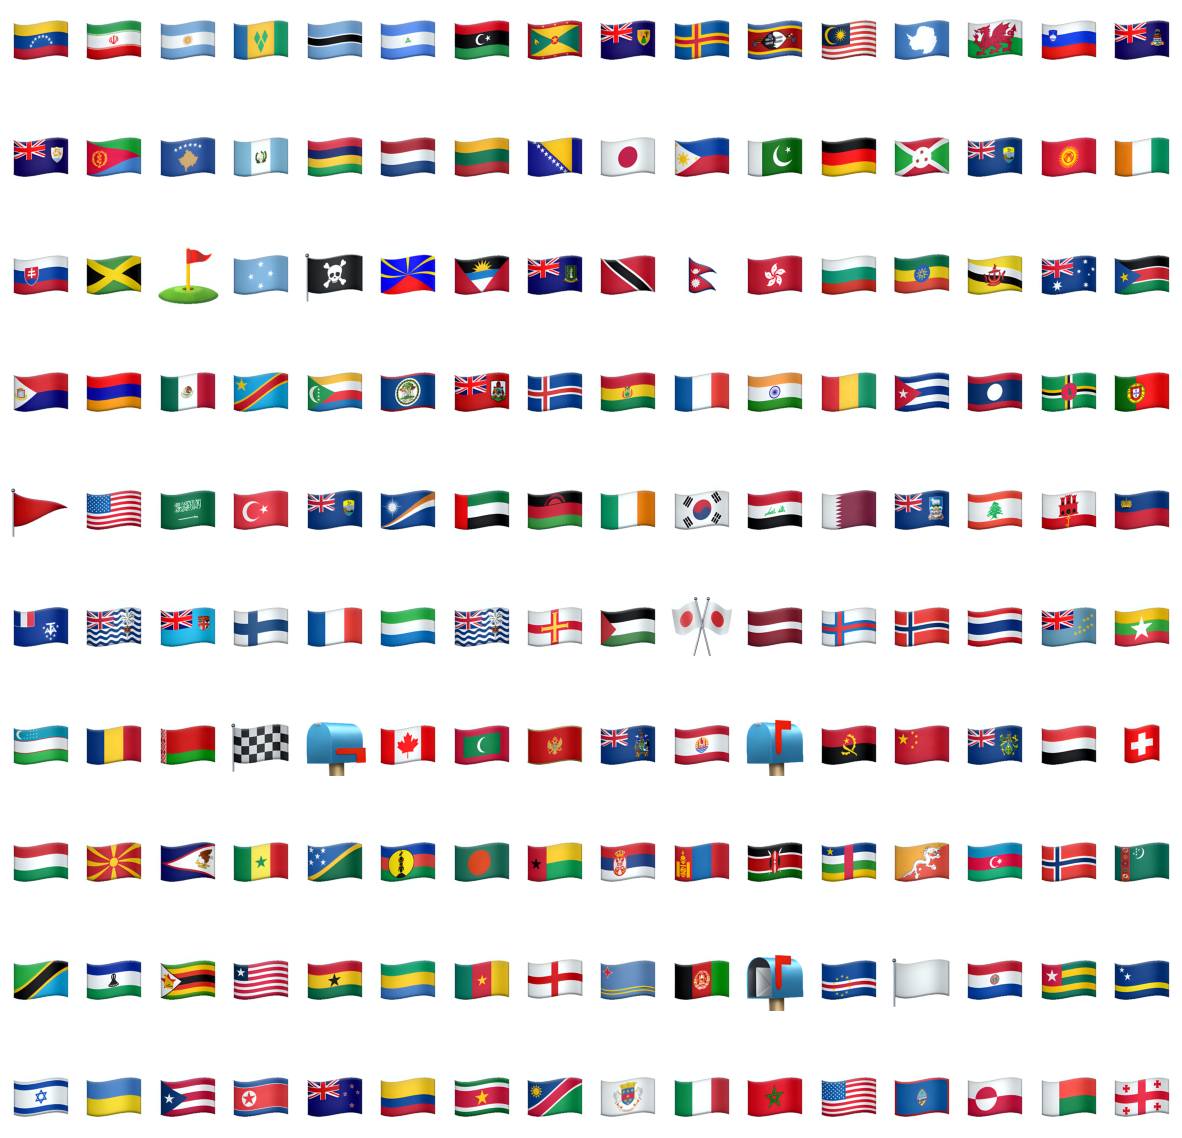

In [5]:
def show_images(images, figsize=(15, 15), rows=10):
    fig, axes = plt.subplots(rows, len(images) // rows, figsize=figsize)

    if len(images) == 1:
        axes = [axes]

    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(title)

    plt.show()
# Display the matching images
target_text = "flag"  # Replace with your specific text
show_images(filter_training(train_dataset, target_text)['image'])

- You are encouraged to reduce the resolution of the dataset to something appropriate for
computational resources (e.g., 64 x 64 x 3).

In [7]:

def reshape_dataset(dataset):
    image_list = []
    for example in dataset:
        image = example['image']
        # Resize the image to 64x64 pixels
        resized_image = image.resize((64, 64))
        # Convert the image to a NumPy array
        image_array = np.array(resized_image)
        image_list.append(image_array)
    # Convert the list of arrays to a single NumPy array
    images = np.array(image_list)
    print(f"Image size: {images.shape}")
    print(f"Number of images: {len(image_list)}")
    return images

# Assuming train_dataset is your dataset
len_train_dataset = len(train_dataset)
images = reshape_dataset(train_dataset)

# Check if the length matches
print(f"Length of train_dataset: {len_train_dataset}")

# Batch and shuffle the data using DataLoader
# batch_size = BATCH_SIZE
# shuffle = True  # Set to True if you want to shuffle the data
# train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)

Image size: (1649, 64, 64, 3)
Number of images: 1649
Length of train_dataset: 1649


Constructing the Generating Neural Network

- fully connected layer that takes an input from noise_dim and outputs to a size of 1024.
- A ReLU activation function.
- Another fully connected layer, this time maintaining a size of 1024.
- nother ReLU activation function.
- A final fully connected layer with a size of 784.
- A TanH activation function, which is used to ensure the output image values are within the range of -1 to 1.

From the Paper:
Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers|
- Item 1



In [8]:
def generator_model(input_size = 100, hidden_size =7*7*256):
    layer1 = [
        nn.Linear(in_features=input_size, out_features=hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        # allows the gradients to flow better through the model 
        nn.LeakyReLU(inplace=True)
    ]
    layer2 = [nn.Unflatten(1, (256, 7, 7))]

    layer3 = [
        nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True)
            
    ]
    layer4 = [
        nn.ConvTranspose2d(128, 1, kernel_size=(3, 3), padding=(1, 1), bias=False),
        nn.Tanh()
    ]
    layers = layer1 + layer2 + layer3 + layer4
    model = nn.Sequential(*layers)
    return model
# Create an instance of the generator
generator = generator_model()

noise = torch.randn(2, 100)
generated_image = generator(noise)
print(generated_image)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

tensor([[[[-0.9600,  0.9991, -0.6209,  1.0000, -0.5692,  0.9149, -0.9464],
          [-1.0000, -0.9999,  0.9989, -0.4982,  0.9977,  1.0000, -0.8187],
          [ 0.6518,  0.5380,  0.1417, -0.9983, -0.6655, -0.9999, -0.9998],
          [-1.0000,  0.6124, -0.9709, -0.9996, -0.9999, -0.2661, -1.0000],
          [ 0.9991,  0.9034, -0.8615, -0.9999, -0.9004, -1.0000, -0.8292],
          [-0.9375,  0.9836, -0.4697, -0.9966,  0.9373,  0.3465, -0.9975],
          [-0.9795,  0.8051, -1.0000, -0.9838, -0.9946, -0.9502, -0.9275]]],


        [[[ 0.6186,  0.8359,  0.9999, -1.0000,  0.9258,  0.9743,  0.9921],
          [ 0.9994,  0.9979, -0.8995,  0.9983, -0.5847, -0.9937,  0.9554],
          [-0.9844,  0.9998, -0.9998,  0.9934,  0.7404,  0.9996, -0.7986],
          [ 0.9636, -0.5234,  0.2701, -0.6899,  0.9953, -0.9992, -1.0000],
          [-0.8834,  0.9167, -0.5127,  0.5304,  0.9996,  0.9997, -1.0000],
          [-0.0411, -0.9992, -0.9931,  0.9808, -0.7837, -0.9989, -0.4505],
          [ 0.9305, -

In [193]:
def discriminator_model():
    layer1 = [
        nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
    ]
    layer2 = [
        nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
            
    ]
    layer3 = [
        nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.3)
    ]
    layers = layer1 + layer2 + layer3 + [nn.Flatten(), nn.Linear(256 * 4 * 4, 1)]

    model = nn.Sequential(*layers)
    return model
discriminator = discriminator_model()
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (4): LeakyReLU(negative_slope=0.01, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (7): LeakyReLU(negative_slope=0.01, inplace=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4096, out_features=1, bias=True)
)


In [194]:
def generator_loss(fake_output):
    target = torch.ones_like(fake_output)
    F.mse_loss(fake_output, target)

In [195]:
def discriminator_loss(real_output, fake_output):
    target_real = torch.ones_like(real_output)
    target_fake = torch.zeros_like(fake_output)

    real_loss = F.mse_loss(real_output, target_real)
    fake_loss = F.mse_loss(fake_output, target_fake)

    total_loss = real_loss + fake_loss
    return total_loss

In [196]:
# Assuming images is a PyTorch tensor

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16
seed = torch.randn(num_examples_to_generate, noise_dim)

# Assuming you already have generator, discriminator, generator_loss, discriminator_loss defined

# Initialize optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
def train_step(images):
    noise = torch.randn(images.size(0), noise_dim)

    # Generator forward pass
    generated_images = generator(noise)

    # Discriminator forward pass for real and fake images
    real_output = discriminator(images)
    fake_output = discriminator(generated_images.detach())

    # Calculate losses
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    # Backpropagation
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    gen_loss.backward(retain_graph=True)
    disc_loss.backward()

    # Update weights
    generator_optimizer.step()
    discriminator_optimizer.step()

In [197]:
for epoch in range(EPOCHS):
    for batch_images in train_dataset:  # Assuming each batch is a tuple of (images, labels)
        # transform = transforms.ToTensor()
        # Apply the transform to each image in the batch
        # transformed_images = [transform(img) for img in np.array(batch_images['image'])]
        # Convert the list of transformed images to a torch tensor
        # transformed_images = torch.stack(batch_images)
        train_step(transformed_images)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not dict